<a href="https://colab.research.google.com/github/Arshad221b/Automatic-Music-Transcription/blob/master/retrain_of_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import numpy as np
import keras
from keras.layers import Dense, Flatten, Reshape, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from  skimage.measure import block_reduce

from PIL import Image
import pretty_midi
import os, os.path
import sys

Using TensorFlow backend.


In [5]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
path_image = '/content/drive/My Drive/MainDATA/data4'
path_midi  = '/content/drive/My Drive/MainDATA/data2'

Populating the interactive namespace from numpy and matplotlib


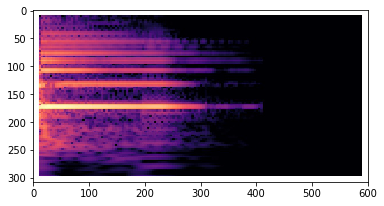

/content/drive/My Drive/MainDATA/data4/song3_13.jpg
(308, 601, 3)


In [7]:
im = '/content/drive/My Drive/MainDATA/data4/song3_13.jpg'
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(str(im))
imgplot = plt.imshow(img)
plt.show()
print(str(im))
print(img.shape)

In [0]:
images = np.ndarray(shape=(2815, 308, 601, 3),dtype=int)

In [0]:
import cv2
import numpy
import glob
import pylab as plt

folders = glob.glob(path_image)

imagenames = []

for folder in folders:
    for f in glob.glob(folder+'/*.jpg'):
        imagenames.append(f)

In [0]:
images_array = np.ndarray(shape=(2815, 308, 601, 3),dtype=int)

In [0]:
from __future__ import division
import pretty_midi
import numpy as np
import sys
import argparse

In [0]:
class util():
  def pretty_midi_to_one_hot(pm, fs=100):

      one_hots = []

      if len(pm.instruments) < 1:
          return 0

      for instrument in pm.instruments:
          one_hot = np.zeros((128, int(fs*instrument.get_end_time())+1))
          for note in instrument.notes:
              # note on
              one_hot[note.pitch, int(note.start*fs)] = 1
              # print('note on',note.pitch, int(note.start*fs))
              # note off
              one_hot[note.pitch, int(note.end*fs)] = 0
              # print('note off',note.pitch, int(note.end*fs))
          one_hots.append(one_hot)

      one_hot = np.zeros((128, np.max([o.shape[1] for o in one_hots])))
      for o in one_hots:
          one_hot[:, :o.shape[1]] += o

      one_hot = np.clip(one_hot,-1,1)
      return one_hot



  def one_hot_to_pretty_midi(one_hot, fs=100, program=1,bpm=120):

      notes, frames = one_hot.shape
      pm = pretty_midi.PrettyMIDI()
      instrument = pretty_midi.Instrument(program=program)

      # prepend, append zeros so we can acknowledge inital and ending events
      piano_roll = np.hstack((np.zeros((notes, 1)),
                              one_hot,
                              np.zeros((notes, 1))))

      # use changes to find note on / note off events
      changes = np.nonzero(np.diff(piano_roll).T)

      # keep track of note on times and notes currently playing
      note_on_time = np.zeros(notes)
      current_notes = np.zeros(notes)

      bps = bpm / 60
      beat_interval = fs / bps
      strong_beats = beat_interval * 2 #(for 4/4 timing)

      last_beat_time = 0

      for time, note in zip(*changes):
          change = piano_roll[note, time + 1]

          if time >= last_beat_time + beat_interval:
              for note in current_notes:
                  time = time / fs

          time = time / fs
          if change == 1:
              # note on
              if current_notes[note] == 0:
                  # from note off
                  note_on_time[note] = time
                  current_notes[note] = 1


          elif change == 0:
              #note off
              pm_note = pretty_midi.Note(
                      velocity=100, #don't care fer now
                      pitch=note,
                      start=note_on_time[note],
                      end=time)
              current_notes[note] = 0
              instrument.notes.append(pm_note)
      pm.instruments.append(instrument)
      return pm

  def slice_to_categories(piano_roll):
      notes_list = np.zeros(128)
      notes = np.nonzero(piano_roll)[0]
      notes = np.unique(notes)

      for note in notes:
          notes_list[note] = 1

      return notes_list

In [0]:
import numpy as np
import keras
from keras.layers import Dense, Flatten, Reshape, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from  skimage.measure import block_reduce

from PIL import Image
import pretty_midi
import os, os.path
import sys
def pretty_midi_to_one_hot(pm, fs=100):

    # Allocate a matrix of zeros - we will add in as we go
    one_hots = []

    if len(pm.instruments) < 1:
        return 0

    for instrument in pm.instruments:
        one_hot = np.zeros((128, int(fs*instrument.get_end_time())+1))
        for note in instrument.notes:
            # note on
            one_hot[note.pitch, int(note.start*fs)] = 1
            # print('note on',note.pitch, int(note.start*fs))
            # note off
            one_hot[note.pitch, int(note.end*fs)] = 0
            # print('note off',note.pitch, int(note.end*fs))
        one_hots.append(one_hot)

    one_hot = np.zeros((128, np.max([o.shape[1] for o in one_hots])))
    for o in one_hots:
        one_hot[:, :o.shape[1]] += o

    one_hot = np.clip(one_hot,-1,1)
    return one_hot

def slice_to_categories(piano_roll):
    notes_list = np.zeros(128)
    notes = np.nonzero(piano_roll)[0]
    notes = np.unique(notes)

    for note in notes:
        notes_list[note] = 1

    return notes_list

In [0]:
def train(x_train, y_train, x_test, y_test):
    batch_size = 64
    num_classes = 128
    epochs = 10

    # input image dimensions
    img_x, img_y = 308, 601

    path = '/content/drive/My Drive/MainDATA/'
    #path = '/mnt/c/Users/chau/Documents/models'
    model_ckpt = os.path.join(path,'ckpt3.h5')
    
    #x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 3)
    #x_test = x_test.reshape(x_train.shape[0], img_x, img_y, 3)
    
    # Convert data to right type
    #x_train = x_train.astype('float32')
    #x_test = x_test.astype('float32')
    #x_train /= 255
    #x_test /= 255
    #print(x_train)
    #print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    model = create_model()
    model.compile(loss=keras.losses.binary_crossentropy,
            optimizer=keras.optimizers.Adam(lr=.0001, decay=1e-6),
            metrics=['accuracy'])

    history = AccuracyHistory()

    checkpoint = ModelCheckpoint(model_ckpt,
            monitor='val_loss',
            verbose=1,
            save_best_only=True,
            mode='min')
    early_stop = EarlyStopping(patience=5, 
            monitor='val_loss',
            verbose=1, mode='min')
    callbacks = [history, checkpoint,early_stop]
    
    model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=callbacks)

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    plt.plot(range(1,101), history.acc)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('loss.png')
    plt.show()

song5_133.jpg
song69_6.jpg
song62_37.jpg
song70_887.jpg
song3_360.jpg
song70_139.jpg
song18_210.jpg
song18_204.jpg
song6_19.jpg
song62_23.jpg
song69_264.jpg
song70_893.jpg
song70_663.jpg
song6_31.jpg
song18_238.jpg
song70_105.jpg
song70_677.jpg
song70_111.jpg
song70_844.jpg
song69_270.jpg
song3_348.jpg
song6_25.jpg
song70_688.jpg
song70_878.jpg
song70_850.jpg
song55_89.jpg
song69_16.jpg
song3_200.jpg
song69_338.jpg
song18_16.jpg
song3_5.jpg
song3_214.jpg
song3_15.jpg
song69_310.jpg
song70_717.jpg
song69_304.jpg
song70_7.jpg
song70_703.jpg
song70_930.jpg
song3_29.jpg
song3_228.jpg
song70_924.jpg
song5_3.jpg
song55_76.jpg
song55_62.jpg
song42_85.jpg
song70_23.jpg
song70_529.jpg
song42_91.jpg
song18_172.jpg
song70_918.jpg
song70_1089.jpg
song18_166.jpg
song70_37.jpg
song70_273.jpg
song70_515.jpg
song42_52.jpg
song69_112.jpg
song42_46.jpg
song70_267.jpg
song70_501.jpg
song69_106.jpg
song70_298.jpg
song18_198.jpg
song70_1077.jpg
song18_199.jpg
song70_1062.jpg
song70_1076.jpg
song42_53.jpg
s

ValueError: ignored

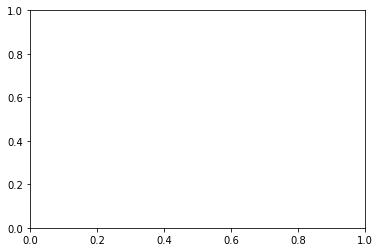

In [15]:
def create_model():
    img_x, img_y = 308, 601
    input_shape = (img_x, img_y, 3)
    num_classes = 128

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1),
        activation='tanh',
        input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(64, (3,3), activation='tanh'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Conv2D(64, (5,5), activation='relu'))
    # Final output layer
    #model.add(Conv2D(128, (5,5), activation='sigmoid'))
    #model.add(Flatten())
    model.add(Flatten())
    #model.add(Dense(64, activation='sigmoid'))
    model.add(Dense(num_classes, activation='sigmoid'))
    return model

class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

def run_cnn(image_path, midi_path):
    # x is spectrogram, y is MIDI
    #jpg_path = '/mnt/d/Workspace/EE379K/data/spectrograms'
    #midi_path = '/mnt/d/Workspace/EE379K/data/split_midi'
    #jpg_path = '/mnt/c/Users/chau/Documents/spectrograms'
    #midi_path = '/mnt/c/Users/chau/Documents/split_midi'
    x_train, y_train = [], []
    img = []
    i = 0
    for filename in os.listdir(image_path):
        print(filename)
        # filename = "daylight_128.jpg"
        m_fn = filename.replace(".jpg", ".mid")
        if os.path.isfile(os.path.join(midi_path, m_fn)):
            pm = pretty_midi.PrettyMIDI(os.path.join(midi_path, m_fn))
            oh = pretty_midi_to_one_hot(pm)
            if type(oh) is not int:
                oh = slice_to_categories(oh)
                #oh = oh.reshape(1, 128)
                y_train.append(oh)
        
                im = Image.open(os.path.join(image_path, filename)) 
                #im = im.crop((14, 13, 594, 301))
                #resize = im.resize((49, 145), Image.NEAREST)
                #resize.load()
                #result = Image.fromarray((visual * 255).astype(numpy.uint8))
                #resize.save("images/" + str(i) + ".jpg")
                arr = np.asarray(im, dtype="float32")
                #print(arr)
                #arr = block_reduce(arr, block_size=(2,2,1), func=np.mean)
                x_train.append(arr)
                #if len(x_train) > 0:
                #    break
                i += 1

    x_train = np.array(x_train)
    #x_train = x_train.reshape(len(x_train), 1)
    y_train = np.array(y_train)
    #print(y_train)
    #print(x_train.shape)
    #print(y_train.shape)
    #print(len(x_train))
    #print(np.shape(x_train))
    #im_array = np.array([np.array
    #x_train = np.array(x_train)
    x_test = np.copy(x_train)
    y_test = np.copy(y_train)
    #x_train, x_test, y_train, y_test = train_test_split(
    #        x_train, y_train, test_size=0.2, random_state=1)
    #print(x_train.shape)
    #print(y_train.shape)
    x_train /= 255.0
    x_test /= 255.0
    train(x_train, y_train, x_test, y_test)


run_cnn(path_image, path_midi)